In [ ]:
# import exifread
# import re
# import pathlib 
# base = pathlib.Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/SAMPLES/")
# out = pathlib.Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/excluded_samples/")
# for _, row in exclude_df.iterrows():
    
#     if row["exclude"] != "yes" and row["exclude"] != "no" and row["exclude"] != "maybe":
        
#         idx = row["exclude"]
#         if "." in idx:
#             rois = [int(x) for x in idx.split(".")]
            
#         else:
#             rois = [int(idx)]
            
            
#         sample = row["Slide"]
            
#         sample_type = row["Tissue"]
        
#         if sample_type == "PT":
#             sample_type = "TU"
        
#         if "(" in sample:
#             sample_name = sample.split(" ")[0]
            
#         else:
#             sample_name = sample
        
#         sample = f"{sample_name}_{sample_type}"
        
#         sample_folder = [s for s in all_samples if sample in s]
#         assert len(sample_folder) == 1
        
#         path = pathlib.Path(os.path.join(base, sample_folder[0]))
#         files = path.glob("**/*.TIF")

#         file_dict = []
#         for file in files:
            
#             with open(file, 'rb') as f:
#                 tags = exifread.process_file(f)
                
#             roi_num = int(re.findall("(?<=[rR][oO][iI]_)[0-9]+", str(tags["Image Tag 0xB0B7"]))[0])
#             file_dict.append({"file": file, "roi": roi_num})

#         df = pd.DataFrame(file_dict)
#         for roi in rois:
            
#             move_files = list(df["file"][df["roi"] == roi])
            
#             for file in move_files:
                
#                 if not os.path.isdir(os.path.join(out, sample_folder[0])):
#                     os.makedirs(os.path.join(out, sample_folder[0]))

#                 os.rename(file, os.path.join(out, sample_folder[0], file.name))

In [ ]:
# import pandas as pd
# import os
# import pathlib

# all_dict = []

# exclude_df = pd.read_csv("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/metadata/exclude_new.csv")
# all_files = [str(x) for x in list(pathlib.Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/RESULTS/").glob("**/*.csv")) if not "panel" in str(x).lower() and not "comma" in str(x)]

# samples = [re.findall("[0-9]+_[0-9]+_[0-9]+-[0-9]+_BM|[0-9]+_[0-9]+_[0-9]+-[0-9]+_TU", f)[0] for f in all_files]

# exclude_sameples = exclude_df["Slide"][exclude_df["exclude"] == "yes"]
# exclude_n = exclude_df["exclude"][exclude_df["exclude"] == "yes"]

# for sample, n in zip(exclude_sameples, exclude_n):
    
#     sample_id = re.findall("[0-9]+-[0-9]+", sample)[0]
    
#     found = [x for x in samples if sample_id in x]
#     if found:
#         all_dict.append({"sample_id": sample_id, "n_csv_files": len(found), "exclude": n}) 
        
# print("ALLES SAMPLES DIE MAL IN DER TABELLE VORKOMMEN\n")

# exclude_sameples = exclude_df["Slide"][np.logical_and(np.logical_and(exclude_df["exclude"] != "yes", exclude_df["exclude"] != "no"), exclude_df["exclude"] != "maybe")]
# exclude_n = exclude_df["exclude"][np.logical_and(np.logical_and(exclude_df["exclude"] != "yes", exclude_df["exclude"] != "no"), exclude_df["exclude"] != "maybe")]

# for sample, n in zip(exclude_sameples, exclude_n):
    
#     sample_id = re.findall("[0-9]+-[0-9]+", sample)[0]
    
#     found = [x for x in samples if sample_id in x]
#     if found:
#         all_dict.append({"sample_id": sample_id, "n_csv_files": len(found), "exclude": n}) 
        
# print("ALLE SAMPLES MIT MIND. EINEM EXCLUDIERTEMV ROI N != 16\n")
# exclude_sameples = exclude_df["Slide"][np.logical_or(exclude_df["exclude"] == "no", exclude_df["exclude"] == "maybe")]
# exclude_n = exclude_df["exclude"][np.logical_or(exclude_df["exclude"] == "no", exclude_df["exclude"] == "maybe")]

# for sample, n in zip(exclude_sameples, exclude_n):
    
#     sample_id = re.findall("[0-9]+-[0-9]+", sample)[0]
    
#     found = [x for x in samples if sample_id in x]
#     if found:
#         all_dict.append({"sample_id": sample_id, "n_csv_files": len(found), "exclude": n}) 
# print("ALLE VOLLKOMMEN INKLUDIERTEN SAMPLES")

In [ ]:
import numpy as np
from scipy import ndimage

def extract_and_pad_objects(image, patch_sz):

    # Find the objects in the labeled image
    objects = ndimage.find_objects(image)

    hsz = patch_sz//2
    im_sz = image.shape

    patches = []
    for i, obj in enumerate(objects):
        
        if obj is None:
            continue
        
        label = i+1
        
        y, x = obj
        
        # Get the coordinates of the object
        cy = np.round((y.start + y.stop)/2, 2).astype(int)
        cx = np.round((x.start + x.stop)/2, 2).astype(int)
        
        # Calculate the object dimensions
        x_max, x_min = np.min([im_sz[0]-1, (cx + hsz)]), np.max([0, (cx - hsz)])
        y_max, y_min = np.min([im_sz[1]-1, (cy + hsz)]), np.max([0, (cy - hsz)])
        
        p_l, p_r = np.abs(np.min([0, (cx - hsz)])), np.abs(np.min([0, im_sz[0]-1-(cx + hsz)]))
        p_t, p_b = np.abs(np.min([0, (cy - hsz)])), np.abs(np.min([0, im_sz[1]-1-(cy + hsz)]))
        
        patch = np.pad(image[y_min:y_max, x_min:x_max], ((p_t, p_b), (p_l, p_r)), mode='constant', constant_values=0)
        
        assert patch.shape == (patch_sz, patch_sz), f"{patch.shape} {x_max} {x_min} {y_max} {y_min} {p_l} {p_r} {p_t} {p_b} {(x_max-x_min)} {p_l + p_r} {(y_max-y_min)} {p_t + p_b} {image[y_min:y_max, x_min:x_max].shape}"
        
        binary_patch = patch == label
        patches.append(binary_patch)
         
    return patches

# Call the function to extract and pad objects
patches = extract_and_pad_objects(mask, patch_sz=128)

In [ ]:
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
import numpy as np

intensities = pd.read_csv("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/intensities-0px/20220517_20220309_20-3072_BM_004.csv", index_col="Object")
region = pd.read_csv("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/regionprops/20220517_20220309_20-3072_BM_004.csv", index_col="Object")
large_seg = tifffile.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/large_refined_segmentation_masks/20220517_20220309_20-3072_BM_004.TIF")
small_seg = tifffile.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/masks-vis/20220517_20220309_20-3072_BM_004.TIF")

In [ ]:
intensities.shape, region.shape, len(np.unique(large_seg)), len(np.unique(small_seg))

idx = intensities.index
idx2 = region.index

missing = np.array(list(set(idx2) - set(idx)))

y = region.loc[missing, "centroid-0"]
x = region.loc[missing, "centroid-1"]

plt.imshow(large_seg, alpha=0.2)
plt.scatter(x,y, s=100, marker="x", color="red")

In [ ]:
def color_by_value(seg, idx, colors) -> np.ndarray:
    
    cols = [colors[idx==i][0] if i in idx else 0 for i in range(idx.max()+1)]

    return np.array(cols)[seg]

In [ ]:
plt.imshow(color_by_value(seg, region.index, abs(np.array(region["centroid-1"]))))

In [ ]:
import cv2

large = cv2.resize(seg, dsize=image.shape)
plt.imshow(large-cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))

In [ ]:
region["assymetry"].max()

In [ ]:
region.columns

In [ ]:
len(region.index)

In [ ]:
len(np.unique(seg))-1

In [ ]:
len(np.unique(image))

In [ ]:
len(intensities.index)

In [ ]:
region

In [5]:
from steinbock.measurement.neighbors import measure_neighbors, NeighborhoodType
import matplotlib.pyplot as plt
import tifffile
import pandas as pd
from scipy.spatial.distance import cdist
from PIPELINE.src.utils import rand_col_seg
import numpy as np

plt.rcParams['figure.figsize'] = 10,10

seg = tifffile.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/large_refined_segmentation_masks/20220517_20220309_20-3072_BM_004.TIF")
intensities = pd.read_csv("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/regionprops/20220517_20220309_20-3072_BM_004.csv", index_col="Object")


In [12]:
class s:
    pass

class roi:
    pass

sample = s
s.data = {3: roi()}
s.data[3] = {"small_segmentation_masks": seg}

from PIPELINE.src.neighbors import extract_neighbors

sample = extract_neighbors(sample, dmax=100)

print(sample.data[3]["neighbors"])


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

       Object  Neighbor   Distance
0        4791      4897  98.535973
1        4791      4935  27.185883
2        4791      4936  84.969429
3        4797      4867  30.465675
4        4797      4907  99.315941
...       ...       ...        ...
23439   12950     12937  83.189514
23440   12963     12937  71.454834
23441   12971     12939  66.731155
23442   12965     12941  36.710777
23443   12968     12960  96.233215

[23444 rows x 3 columns]


In [3]:
from PIPELINE.src.neighbors import get_neighbors

TypeError: Union[arg, ...]: each arg must be a type. Got [<NeighborhoodType.CENTROID_DISTANCE: functools.partial(<function _measure_centroid_distance_neighbo.

In [11]:
from steinbock.measurement.neighbors import measure_neighbors, NeighborhoodType
measure_neighbors(seg, NeighborhoodType.CENTROID_DISTANCE, "euclidean", dmax=100)

,Object,Neighbor,Distance
0,4791,4897,98.535973
1,4791,4935,27.185883
2,4791,4936,84.969429
3,4797,4867,30.465675
4,4797,4907,99.315941
...,...,...,...
23439,12950,12937,83.189514
23440,12963,12937,71.454834
23441,12971,12939,66.731155
23442,12965,12941,36.710777


In [2]:

def neighbors(intensities, seg, min_dist=0, max_dist=200):
    
    obj_index = intensities.index
    y = intensities["centroid-0"]
    x = intensities["centroid-1"]
    
    positions = np.array([x, y]).T

    
    dists = cdist(positions, positions, metric="euclidean")
    
    neighs = {}
    for obj, i in zip(obj_index, dists):
        
        idx = np.where(np.logical_and(i>min_dist, i<max_dist))[0]

        neighs[obj] = positions[idx]
        
    return neighs

        
neigh_dict = neighbors(intensities,seg, min_dist=100, max_dist=500)

In [3]:
neigh_dict.keys()

dict_keys([4791, 4797, 4820, 4829, 4833, 4837, 4838, 4841, 4842, 4846, 4847, 4850, 4852, 4855, 4858, 4859, 4861, 4862, 4865, 4866, 4867, 4870, 4871, 4875, 4877, 4879, 4880, 4881, 4882, 4883, 4884, 4886, 4888, 4893, 4896, 4897, 4903, 4904, 4906, 4907, 4908, 4912, 4916, 4917, 4924, 4925, 4927, 4931, 4935, 4936, 4939, 4943, 4944, 4946, 4951, 4953, 4955, 4958, 4961, 4969, 4971, 4972, 4978, 4981, 4986, 4987, 4991, 4993, 4994, 4995, 4998, 4999, 5000, 5002, 5005, 5006, 5008, 5010, 5012, 5019, 5021, 5022, 5024, 5025, 5026, 5030, 5043, 5045, 5046, 5048, 5049, 5057, 5058, 5059, 5063, 5069, 5070, 5072, 5073, 5076, 5077, 5078, 5086, 5088, 5089, 5090, 5095, 5096, 5100, 5101, 5102, 5104, 5105, 5107, 5108, 5109, 5110, 5111, 5112, 5120, 5127, 5131, 5133, 5134, 5141, 5144, 5147, 5150, 5151, 5152, 5155, 5156, 5157, 5158, 5161, 5162, 5163, 5167, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5180, 5182, 5183, 5186, 5188, 5189, 5193, 5196, 5197, 5200, 5201, 5202, 5204, 5205, 5209, 5210, 5219, 5220,

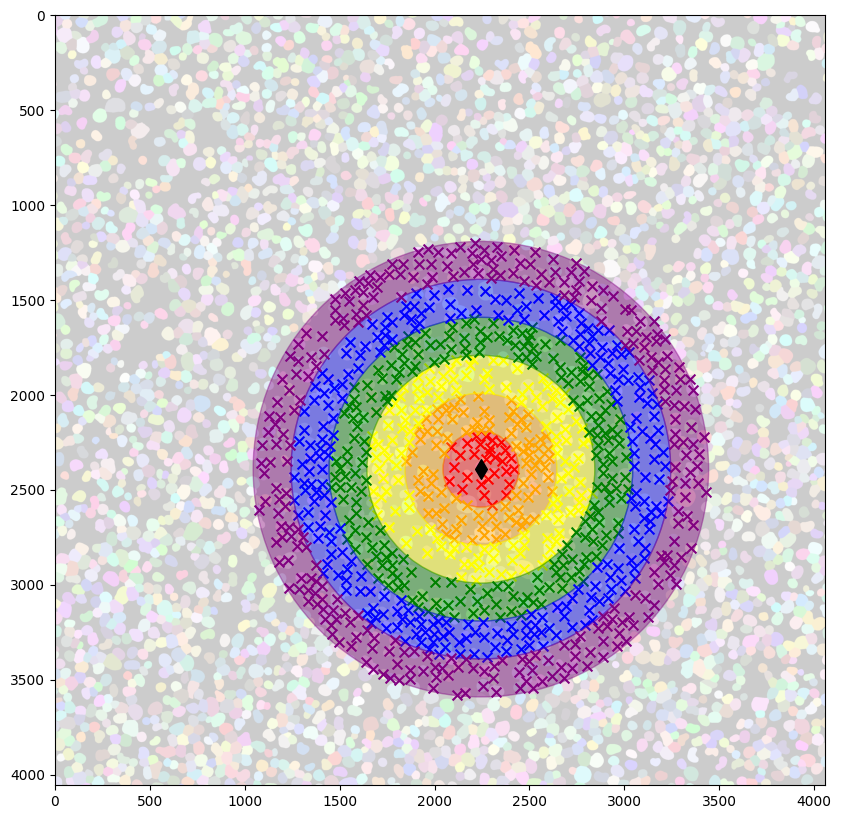

In [4]:
from matplotlib.patches import Wedge

to_plot = 9545

fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.imshow(rand_col_seg(seg), alpha=0.2)
dists = [200*x for x in range(7)]
colors = ["red", "orange", "yellow", "green", "blue", "purple", "black"]
x = intensities.loc[to_plot, "centroid-0"]
y = intensities.loc[to_plot, "centroid-1"]

for i in range(len(dists)-1):

    neigh_dict = neighbors(intensities, seg, dists[i], dists[i+1])
    ax.scatter(neigh_dict[to_plot][:,0], neigh_dict[to_plot][:,1], s=50, color=colors[i], marker="x")
    circ = Wedge((y, x), dists[i+1], 0, 360, width=dists[i+1]-dists[i], color=colors[i], alpha=0.4)
    
    ax.add_patch(circ)

plt.scatter(y,x,marker="d", color="black", s=100)
plt.show()

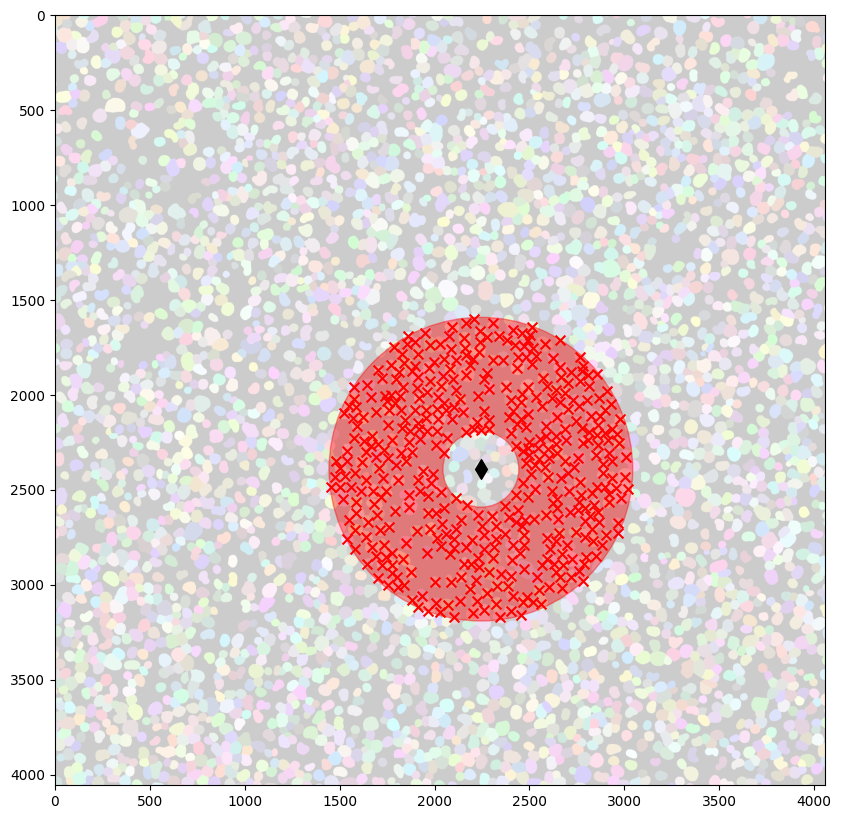

In [7]:

fig, ax = plt.subplots(1, 1, figsize=(10,10))

min_dist, max_dist = 200, 800

ax.imshow(rand_col_seg(seg), alpha=0.2)
neigh_dict = neighbors(intensities, seg, min_dist, max_dist)
ax.scatter(neigh_dict[to_plot][:,0], neigh_dict[to_plot][:,1], s=50, color="red", marker="x")
circ = Wedge((y, x), max_dist, 0, 360, width=max_dist-min_dist, color="red", alpha=0.4)

ax.add_patch(circ)

plt.scatter(y,x,marker="d", color="black", s=100)
plt.show()

In [ ]:
from PIPELINE.log_utils.parse_logfiles import parse_sample_logfile
import pathlib

In [ ]:
files = pathlib.Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/new_logs/").glob("*.log")

ids = []
for file in files:
    ret = parse_sample_logfile(file)
    if not isinstance(ret, type(None)):
        ids.extend(ret)
    
ids

In [ ]:
import os
base = pathlib.Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/new_logs")

for s_id in np.unique(ids):
    print(s_id)
    files = base.glob(f"*{s_id}*")
    #print(len(list(files)))
    
    for file in files:
        print(file)
        #os.remove(file)pass
        pass

In [ ]:
20220603_20220106_16-5841_BM 20220604_20220110_04-2066_BM 20220607_20220201_06-3859_BM 20220927_20220809_07-4158_TU 20221019_20220908_21-00560_TU 

In [ ]:
import tifffile
from tqdm import tqdm
files = pathlib.Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/large_segmentation_masks").glob("*.tif")

for file in tqdm(files):
    sz = np.array(tifffile.imread(file).shape)
    if np.any(np.logical_or(sz > 4100, sz < 4000)):
        print(file.stem)
        print(tifffile.imread(file).shape)


In [ ]:
    sz = np.array(tifffile.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/large_segmentation_masks/").shape)

In [ ]:
from steinbock.measurement import neighbors


In [ ]:
neighs = neighbors.measure_neighbors(seg, neighbors.NeighborhoodType.EUCLIDEAN_BORDER_DISTANCE, metric="euclidean", dmax=100)

In [ ]:
neighs

In [ ]:
intensities = pd.read_csv("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/regionprops/20220517_20220309_20-3072_BM_004.csv")

In [ ]:
tmp = neighs[neighs["Object"] == 8412]
tmp = tmp.append({"Object": 8412, "Neighbor": 8412, "Distance": 0}, ignore_index=True)

In [ ]:
locs = intensities[[x in np.array(tmp["Neighbor"]) for x in intensities["Object"]]][["centroid-0", "centroid-1", "Object"]]
locs.rename(columns={"Object": "Neighbor"}, inplace=True)
locs

In [ ]:
res = pd.merge(tmp, locs, on="Neighbor")
res["normed_dist"] = res["Distance"]/res["Distance"].max()

In [ ]:
res

In [ ]:
middle = res[res["Neighbor"]==8412]
middle

In [ ]:
import matplotlib

cmap = matplotlib.colormaps["gnuplot2"]

In [ ]:
plt.imshow(seg)
for _, r in res.iterrows():
    plt.scatter(r["centroid-1"], r["centroid-0"], s=10)
    plt.plot([middle["centroid-1"], r["centroid-1"]], [middle["centroid-0"], r["centroid-0"]], color=cmap(r["normed_dist"]))
    
plt.xlim(float(middle["centroid-1"]-500), float(middle["centroid-1"]+500))
plt.ylim(float(middle["centroid-0"]-500), float(middle["centroid-0"]+500))

In [ ]:
import exifread
import re

In [ ]:
# base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/SAMPLES/"
# excluded_folder = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/excluded_samples"
# to_exclude = [["20220607_20220201_06-3859_BM", 1], ["20220603_20220106_16-5841_BM", 6]]

# for sample, roi in to_exclude:
    
#     sample_id = re.findall("[0-9]+-[0-9]+", sample)[0]
    
#     files = pathlib.Path(base).glob(f"**/*{sample_id}*.TIF")


#     for file in files:

        
#         with open(file, 'rb') as f:
#             tags = exifread.process_file(f)
#         roi_num = int(re.findall("(?<=[rR][oO][iI]_)[0-9]+", str(tags["Image Tag 0xB0B7"]))[0])
        
#         if roi_num == roi:
            
#             excluded_sample_folder = pathlib.Path(excluded_folder).joinpath(sample)
#             if not excluded_sample_folder.exists():
#                 excluded_sample_folder.mkdir()
    
#             file.rename(pathlib.Path(excluded_sample_folder).joinpath(file.name))
        
# # 20220607_20220201_06-3859_BM ROI 1 
# # 20220603_20220106_16-5841_BM ROI 6 

In [ ]:
from pathlib import Path
import numpy as np
import re 

def _copy(self, target):
    import shutil
    assert self.is_file()
    shutil.copyfile(str(self), str(target))  # str() only there for Python < (3, 6)

Path.copy = _copy

all_samples = list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/SAMPLES/").glob("*"))

np.random.shuffle(all_samples)

for sample in all_samples[:5]:
    
    if "TU" not in str(sample):
        continue
    
    sample_id = re.findall("[0-9]+-[0-9]+_[A-Z]{2}", str(sample))[0]
    print(sample_id)
    results_files = list(pathlib.Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/").glob(f"**/*{sample_id}*"))
    
    for file in results_files:
        if "csv" in str(file):
            continue
        print(file)
        new_name = "_".join(str(file).split("/")[-2:])
        new_name = Path(f"/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/to_delete/validate/{new_name}")
        print(new_name)
        file.copy(new_name)


In [ ]:
for i, n in enumerate(['CD8a_Sm154', 'CD279_Ho165', 'S100B_Dy161', 'CD11c_Nd150', 'CD274_Gd160', 'PNMT_Er166', 'HLA-DR_Nd143', 'MPO_Y89', 'GZMB_Yb173', 'CD56_Er170', 'GD2_Gd155', 'H4K12Ac_Er167', 'CD10_Gd158', 'CD24_Eu151', 'SOX10_Dy162', 'clPARP_Yb176', 'CD45_Eu153', 'CD11b_Nd142', 'CXCR4_Tb159', 'CHGA_Dy164', 'IDO_Yb172', 'CD34_Gd156', 'LUM_Sm149', 'ELAVL4_Yb174', 'GATA3_Er168', 'Fibronectin_La139', 'Vimentin_Pt196', 'CD4_Yb171', 'CD14_Lu175', 'DNA1_Ir191', 'H3K9Ac_Nd146', 'DNA1_Ir193', 'CXCR2_Nd145', 'PRPH_Nd144', 'Ki-67_Tm169', 'HLA-ABC_Sm147', 'CD20_Nd148', 'CD44_In115', 'CD3_Sm152', 'FOXP3_Dy163', 'CD15_Bi209', 'IF1_DAPI', 'IF2_GD2', 'IF3_CD45']):
    
    if "cd10" in n.lower():
        print(n, i)

In [ ]:
['CD8a_Sm154', 'CD279_Ho165', 'S100B_Dy161', 'CD11c_Nd150', 'CD274_Gd160', 'PNMT_Er166', 'HLA-DR_Nd143', 'MPO_Y89', 'GZMB_Yb173', 'CD56_Er170', 'GD2_Gd155', 'H4K12Ac_Er167', 'CD10_Gd158', 'CD24_Eu151', 'SOX10_Dy162', 'clPARP_Yb176', 'CD45_Eu153', 'CD11b_Nd142', 'CXCR4_Tb159', 'CHGA_Dy164', 'IDO_Yb172', 'CD34_Gd156', 'LUM_Sm149', 'ELAVL4_Yb174', 'GATA3_Er168', 'Fibronectin_La139', 'Vimentin_Pt196', 'CD4_Yb171', 'CD14_Lu175', 'DNA1_Ir191', 'H3K9Ac_Nd146', 'DNA1_Ir193', 'CXCR2_Nd145', 'PRPH_Nd144', 'Ki-67_Tm169', 'HLA-ABC_Sm147', 'CD20_Nd148', 'CD44_In115', 'CD3_Sm152', 'FOXP3_Dy163', 'CD15_Bi209', 'IF1_DAPI', 'IF2_GD2', 'IF3_CD45'][16]

In [1]:
from pathlib import Path
import numpy as np
import re 
all_samples = list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEWEST_RESULTS/").glob("**/*.*"))

In [2]:
ids = [re.findall("[0-9]+-[0-9]+_[A-Z]{2}", str(s))[0] for s in list(all_samples)]

In [3]:
len(np.unique(ids))

170

In [ ]:
np.random.shuffle(ids)

In [ ]:
import pandas as pd
from tqdm import tqdm
results = []
sample_ids = []
for sample in tqdm(ids):
    
    all_new_results = list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/").glob(f"intensities-0px/*{sample}*.csv"))
    
    if "TU" in sample:
        
        all_old_results = list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20230112_DIMR_Ilastik/PT/20230308_sc_data/simple_segmentation/intensities_no-dil").glob(f"*{sample}*.csv"))

        
    elif "BM" in sample:
    
        all_old_results = list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20230112_DIMR_Ilastik/BM/20230308_sc_data/simple_segmentation/intensities_no-dil").glob(f"*{sample}*.csv"))
        
    # print(all_new_results)
    # print(all_old_results)
    
    for f in all_new_results:
        
        roi = re.findall("[0-9]{3}(?=\.csv)", str(f))[0]
        for fo in all_old_results:
            roi_o = re.findall("[0-9]{3}(?=_IF)", str(fo))[0]
            
            
            if int(roi_o) == int(roi):
                old_f = fo
                break
                
        new = pd.read_csv(f, index_col="Object")
        old = pd.read_csv(fo, index_col="Object")
        new = new[[x for x in new.columns if not "80" in x]]
        old = old[[x for x in old.columns if not "80" in x]]
        
        new_cols = {}
        for c in new.columns:
            
            metal = re.findall("(?<=_).+(?=_)", str(c))[0]
            new_cols[c] = metal
            
        old_cols = {}
        for c in old.columns:
            
            metal = re.findall("(?<=_).+(?=_)", str(c))[0]
            if "dapi" in c.lower():
                metal = "DAPI"
            if "GD2-IF2" in c:
                metal = "GD2"
            if "CD56-IF3" in c:
                if "TU" in sample:
                    metal = "CD45"
                elif "BM" in sample:
                    metal = "CD56"
                
            old_cols[c] = metal
        
        new = new.rename(columns=new_cols)
        old = old.rename(columns=old_cols)
        
        all_marker = []
        cols = []
        for col in new:
            # if "DAPI" in col or "CD45" in col or "CD56" in col or "GD2" in col:
            #     continue
            new_vals = np.array(new[col])
            old_vals = np.array(old[col])
            
            all_marker.append(new_vals.mean()-old_vals.mean())
            
            cols.append(col)
        results.append(all_marker)
        sample_ids.append(f"{sample}_{roi}")
        
            #results.append({"metal": col, "new":np.round(new_vals.mean(), 4), "old": np.round(old_vals.mean(), 4)})
            
        #results = pd.DataFrame(results).to_excel(f"/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/to_delete/validate/{sample}_{roi}.xlsx")

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 20

res = pd.DataFrame(np.array(results), columns=cols, index=sample_ids)

sb.heatmap(res, vmin=0, vmax=.25)

In [ ]:
res.max()

In [ ]:
list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/").glob(f"**/*{sample}*.csv"))

In [ ]:
from PIPELINE.src.background_correction import BackgroundCorrecter
from PIPELINE.src.sample import PIPELINE_Sample, save_sample

bc = BackgroundCorrecter("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/ILP_NEW_BM")

In [ ]:
sample = PIPELINE_Sample("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/SAMPLES/20220519_20211222_03-0313_BM/")

In [ ]:
from cv2 import resize
import numpy as np

for roi in sample.roi_nums:
    
    sample.data[roi] = {}
    sample.mod0[roi].image_stack = np.array([resize(x, dsize=(696, 696)) for x in sample.mod0[roi].image_stack])
 
    all_stack = np.concatenate((sample.mod0[roi].image_stack, sample.mod1[roi].image_stack), axis=0)
    all_channels = np.concatenate((sample.mod0[roi].stack_channels, sample.mod1[roi].stack_channels))
    
    sample.data[roi]["data_corrected"] = all_stack
    sample.data[roi]["cliped_stack"] = all_stack
    sample.data[roi]["all_channels"] = all_channels
    
sample.all_channels = all_channels
    
sample.KEEP_CHANNELS = ["IF1_DAPI", "IF2_GD2", "IF3_CD56"]

In [ ]:
for roi, data in sample.data.items():
    corrected, masks, new_channels = bc.correct(data["cliped_stack"], data["all_stack"], channels=data["all_channels"], keep_channels=sample.KEEP_CHANNELS)
    sample.data[roi]["data_corrected"] = corrected
    sample.data[roi]["data_channels"] = new_channels

In [ ]:
from PIPELINE.src.normalize import minmax_sample, percentile_clip

sample = percentile_clip(sample)

for roi, data in sample.data.items():
    
    sample.data[roi]["data_corrected"] = data["cliped_stack"]

minmax_sample(sample)

In [ ]:
len(['20220526_20211229_15-1320_BM' '20220604_20220110_04-2066_BM' '20220725_20220216_17-2178_BM' '20220929_20220906_02-4010_TU' '20220607_20220201_06-3859_BM' '20220920_20220728_06-1579_BM' '20220520_20220223_07-1861_BM_R' '20220603_20220106_16-5841_BM' '20220607_20220303_15-4510_BM_R' '20220921_20220802_09-1071_BM' '20220520_20220223_06-2373_BM_R' '20220803_20220308_08-3380_BM_N' '20220517_20220309_20-3072_BM_N' '20220607_20220203_15-1814_BM' '20221019_20220908_20-6834_TU' '20220614_20220205_14-0734_BM' '20221028_20221019_20-0568_BM' '20220629_20220209_06-2655_BM' '20220925_20220804_18-1061_TU' '20220725_20220215_15-1102_BM' '20210606_20210131_15-2770_BM' '20220727_20220222_09-1901_BM' '20220613_20220204_17-0390_BM' '20220825_20220323_13-3512_BM' '20220728_20220301_08-1131_BM' '20220525_20220223_06-2847_BM_R' '20220629_20220208_15-2176_BM' '20220725_20220216_03-0529_BM' '20220805_20220309_21-3251_BM_N' '20220519_20211222_03-0313_BM' '20220604_20220110_16-0124_BM' '20220921_20220811_22-01713_BM_R' '20220629_20220209_16-3184_BM' '20220630_20220210_14-0025_BM' '20220630_20220210_04-0164_BM' '20220808_20220317_12-2919_BM_N' '20220804_20220308_02-2505_BM_N' '20220525_20220224_11-2786_BM_R' '20220929_20220825_03-3901_TU' '20220606_20220131_18-2341_BM' '20220922_20211214_18-2600_BM' '20220726_20220218_14-3918_BM' '20220803_20220307_08-2864_BM_N' '20220606_20220129_18-1404_BM' '20220628_20220208_15-2444_BM' '20220728_20220307_12-1746_BM_N' '20220804_20220308_17-0625_BM_N' '20220603_20220106_14-3965_BM' '20220929_20220825_03-0529_TU' '20220921_20220802_04-0502_BM' '20220605_20220128_09-0092_BM' '20220803_20220307_11-2244_BM_N' '20220728_20220303_18-4528_BM_R' '20220826_20220329_20-10479_BM' '20220826_20220323_21-01363_BM' '20220922_20220811_08-4133_BM' '20220608_20220204_17-0492_BM' '20220725_20220215_18-3011_BM' '20220606_20220129_15-1576_BM' '20220805_20220314_18-0293_BM_N' '20220630_20220209_15-3531_BM' '20221020_20220908_20-2831_TU' '20220927_20220810_05-3938_TU' '20220630_20220214_16-1370_BM' '20220806_20220316_11-2007_BM_N' '20220805_20220421_16-1853_BM_N' '20220604_20220112_03-0298_BM' '20220806_20220316_04-0169_BM_N' '20220925_20220804_17-2178_TU' '20220806_20220314_17-4510_BM_N' '20220526_20211228_14-1331_BM' '20220630_20220210_18-1462_BM' '20220728_20220307_16-1867_BM_N' '20220927_20220810_09-0411_TU' '20220525_20211227_09-0920_BM' '20220825_20220421_21-0850_BM_N' '20220926_20220809_16-1927_TU' '20220928_20220810_04-2772_TU' '20220727_20220222_16-4503_BM' '20220922_20220412_18-4452_BM_RR' '20220628_20220208_17-3394_BM' '20220604_20220112_18-3728_BM' '20220608_20220204_15-2468_BM' '20220805_20220309_15-4399_BM_N' '20220525_20211227_14-3450_BM' '20220728_20220222_04-1388_BM' '20220531_20211230_18-2306_BM' '20220614_20220207_18-5770_BM' '20220602_20220105_16-3300_BM' '20220605_20220128_14-2892_BM' '20220601_20220103_13-4453_BM' '20220808_20220421_19-1084_BM_N' '20220826_20220727_18-4876_BM_R' '20220606_20220131_09-1107_BM' '20220522_20211224_06-3069_BM' '20220601_20220104_04-0813_BM' '20221018_20220906_03-3536_TU' '20220602_20220105_14-2253_BM' '20220226_20220224_07-2453_BM_R' '20220929_20220825_03-0313_TU' '20220725_20220215_04-0645_BM' '20220608_20220203_16-1783_BM' '20220926_20220809_13-4453_TU' '20220531_20211230_13-4339_BM' '20220628_20220208_14-3093_BM' '20220613_20220204_18-3107_BM' '20220531_20211229_14-0309_BM' '20220726_20220217_18-0892_BM' '20220830_20220727_19-3897_BM' '20220927_20220809_07-4158_TU' '20220630_20220210_14-2675_BM' '20220920_20220728_11-2208_BM' '20220602_20220106_16-1454_BM' '20220604_20220111_15-0950_BM' '20220927_20220810_05-0034_TU' '20220605_20220128_04-1614_BM' '20220613_20220205_17-4599_BM' '20220628_20220207_03-4975_BM' '20220525_20211224_11-3238_BM' '20220601_20220224_07-3302_BM_R' '20220726_20220221_02-2370_BM' '20221028_20221019_19-5754_BM' '20220805_20220309_09-3855_BM_N' '20220926_20220809_16-1934_TU' '20220629_20220209_16-0213_BM' '20220602_20220104_18-1571_BM' '20220808_20220316_13-3767_BM_N' '20220614_20220207_17-2022_BM' '20220607_20220201_12-2237_BM' '20220531_20211230_19-2548_BM' '20220531_20220228_15-0229_BM_R' '20220804_20220308_02-1706_BM_N' '20220601_20220103_04-2136_BM' '20220921_20220802_03-4334_BM' '20221019_20220908_20-3529_TU' '20220607_20220201_15-1549_BM' '20220920_20220727_09-1114_BM' '20221018_20220906_03-1501_TU' '20220803_20220307_15-0438_BM_N' '20220603_20220106_04-0435_BM' '20220726_20220217_03-2072_BM' '20221019_20220908_21-00560_TU' '20220926_20220809_10-2679_TU' '20220614_20220207_10-1771_BM' '20220603_20220110_19-4756_BM' '20220929_20220825_02-2222_TU' '20220526_20211228_04-0968_BM' '20220920_20220727_16-0601_BM' '20220522_20211223_17-3502_BM' '20220605_20220112_09-1021_BM' '20220701_20220214_14-2108_BM' '20220605_20220128_13-2083_BM' '20220530_20211229_18-2796_BM' '20220922_20211227_18-5369_BM' '20220727_20220221_15-4020_BM' '20220701_20220214_11-1272_BM' '20220613_20220205_03-3812_BM' '20220806_20220314_16-0215_BM_N' '20220608_20220203_15-0813_BM' '20220603_20220110_04-0767_BM' '20220808_20220316_21-01285_BM_N' '20220805_20220309_02-3448_BM_N' '20220701_20220214_15-2831_BM' '20220725_20220216_12-0890_BM' '20221018_20220906_03-0170_TU' '20220604_20220111_18-2231_BM' '20220614_20220205_11-0521_BM' '20220804_20220308_09-3712_BM_N' '20221018_20220907_13-3719_TU' '20220927_20220809_08-4160_TU' '20220605_20220128_15-3617_BM' '20220608_20220203_15-4368_BM' '20220522_20211224_11-0262_BM'])

In [ ]:
from pathlib import Path

sample = "03-0313_BM_007"                           
t = "intensities-0px"

old = list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEW_RESULTS/").glob(f"*{t}*/*{sample}*.csv"))[0]
new = list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEWEST_RESULTS/").glob(f"*{t}*/*{sample}*.csv"))[0]
daria = list(Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20230112_DIMR_Ilastik/BM/20230308_sc_data/simple_segmentation/intensities_no-dil").glob(f"*{sample}*.csv"))[0]


In [ ]:
import pandas as pd

old_df = pd.read_csv(old)
new_df = pd.read_csv(new)
daria = pd.read_csv(daria)

In [ ]:
import seaborn as sb 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 10

sb.heatmap(old_df.mean(axis=0).squeeze() - new_df.mean(axis=0).squeeze(), vmin=-0.1, vmax=0.1, cmap="bwr")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.scatter(range(old_df.shape[1]), old_df.mean(axis=0).squeeze() - new_df.mean(axis=0).squeeze())
ax.set_xticks(range(old_df.shape[1]));
ax.set_xticklabels(old_df.columns, rotation=90);

In [46]:
import os 
import tifffile
from pathlib import Path
import re
import pandas as pd

base_new = Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/TEST_RESULTS/")
base_old = Path("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEWEST_RESULTS/")

samples = ["20220602_20220106_16-1454_BM", "20221018_20220906_03-1501_TU"]

for sample in samples:
    
    new_files = list(base_new.glob(f"**/*{sample}*"))
    old_files = list(base_new.glob(f"**/*{sample}*"))
    
    for file in new_files:
        
        roi = re.findall("(?<=_)[0-9]{3}(?=\.)", str(file))[0]

        if "intensities-1px" in str(file).lower():
            
            matching_file = [x for x in old_files if "intensities-1px" in str(x) and roi in str(x)][0]
            
            
        elif "intensities-0px" in str(file).lower(): 

            matching_file = [x for x in old_files if "intensities-0px" in str(x) and roi in str(x)][0]
            
              
        elif "regionprops" in str(file).lower():

            matching_file = [x for x in old_files if "regionprops" in str(x) and roi in str(x)][0]          
         
        else:
            continue
           
        new = pd.read_csv(file)
        old = pd.read_csv(matching_file)

        print(np.any(new-old))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
